In [1]:
# !pip install wordcloud
# !pip install spacy
# !pip install faiss-cpu
# !pip install python-dotenv

In [2]:
import pandas as pd, re, unicodedata
from collections import Counter
import spacy, re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import time, json, sys
import re, unicodedata
from concurrent.futures import ThreadPoolExecutor, as_completed
from groq import Groq
import unicodedata
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd
from typing import Sequence, Tuple

from dotenv import load_dotenv
import os

load_dotenv()
api1 = os.getenv('llama3_70b_8192')
api2 = os.getenv('gemma2_9b_it')
api3 = os.getenv('llama_instant')
api4 = os.getenv('llama3_8b')

In [3]:
legal_data_path = r".\Datos\sentencias_pasadas.xlsx"

In [4]:
legal_data = pd.read_excel(legal_data_path).drop(columns='Tipo')

In [5]:
legal_data.shape

(329, 7)

In [6]:
legal_data.head(3)

,#,Relevancia,Providencia,Fecha Sentencia,Tema - subtema,resuelve,sintesis
0,1,966965.0,T-185/22,2022-05-31,NaN,en nombre del pueblo y por mandato de la Const...,En este caso se formula la acción de tutela en...
1,3,963168.0,T-356/21,2021-10-15,ACCIÓN DE TUTELA PARA PROTEGER EL DERECHO A LA...,en nombre del pueblo y por mandato de la Const...,El peticionario considera que los accionantes ...
2,5,956201.0,T-351/22,2022-10-07,ACCIÓN DE TUTELA PARA PROTEGER EL DERECHO A LA...,"administrando justicia en nombre del Pueblo, y...",El periodista accionante acusa al abogado acci...


In [7]:
def load_spacy_model(model_name):
    try:
        return spacy.load(model_name, disable=["ner"])
    except OSError:
        print(f"model not loaded. downloading model: '{model_name}'...")
        spacy.cli.download(model_name)
        return spacy.load(model_name)

nlp = spacy.load_spacy_model("es_core_news_sm") 

STOP = nlp.Defaults.stop_words

TOKEN_RE = re.compile(r"\b\w+\b", re.UNICODE)

def clean_lemmas(doc):
    """Devuelve lemas filtrados y en minúsculas para un spaCy Doc."""
    return [
        tok.lemma_.lower()
        for tok in doc
        if tok.is_alpha                       # solo letras
           and tok.lemma_.lower() not in STOP
    ]

def word_count_generator(df):

    all_lemmas = (
        lemma
        for doc in nlp.pipe(df["sintesis"].astype(str), batch_size=256)
        for lemma in clean_lemmas(doc)
    )
    counts = Counter(all_lemmas)                      # {lemma: frecuencia}
    
    freq_df = (
        pd.DataFrame(counts.items(), columns=["lemma", "count"])
          .sort_values("count", ascending=False)
          .reset_index(drop=True)
    )
    
    wc = WordCloud(
            width=1600, height=900,
            background_color="white",
            colormap="viridis",
            prefer_horizontal=0.9,
            normalize_plurals=False
        ).generate_from_frequencies(counts)

    return wc, freq_df

def word_plot(wc_var):

    plt.figure(figsize=(7, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return    

In [8]:
MODEL_KEYS = [
    ("llama3-70b-8192",      api1),
    ("gemma2-9b-it",         api2),
    ("llama-3.1-8b-instant", api3),
    ("llama3-8b-8192",       api4),
]

MODELS  = [m for m, _ in MODEL_KEYS]
CLIENTS = [Groq(api_key=k) for _, k in MODEL_KEYS]
CALL_INTERVAL = 60 / 29.5

# ── Groq API Call Worker ──────────────────────────────────────────────────
def worker(task):
    idx, content, column = task
    base_slot = idx % len(MODELS)

    # prompt = (
    #         "En español, resume el siguiente texto en 20 palabras simples. "
    #         "Entrega **únicamente** un JSON válido con clave \"answer\" y máximo 100 tokens. "
    #         f"Texto: {content}"
    #     )

    prompt = (
        "En español, en una sola oración neutra (≤30 palabras) resume quién pidió qué, el resultado y por qué, tal como aparece en el texto."
        "Usa terminología legal, pero simple sin ser tan sofisticada, pero precisa"
        "Devuelve solo un JSON válido: {\"answer\":\"...\"}. "
        f"Texto: {content}"
    )

    for attempt in range(3):
        slot = (base_slot + attempt) % len(MODELS)
        model, client = MODELS[slot], CLIENTS[slot]

        time.sleep(CALL_INTERVAL)
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                max_completion_tokens=100,
                response_format={"type": "json_object"},
            )
            result_json = json.loads(resp.choices[0].message.content)
            result = result_json.get("answer", "")
            print(f"✔︎ Model{slot+1} row{idx+1} ({column}) (try{attempt+1})", flush=True)
            return idx, result
        except Exception as e:
            print(f"✖︎ Model{slot+1} row{idx+1} ({column}) failed (try{attempt+1}): {e}",
                  file=sys.stderr, flush=True)

    print(f"⚠︎ Row{idx+1} ({column}) gave up after 3 tries", file=sys.stderr, flush=True)
    return idx, "Failed"

# ── Main ──────────────────────────────────────────────────────────────────
def LLM_aumentation(df):
    tasks = []
    for idx, row in df.iterrows():
        tasks.append((idx, row['resuelve'], "Sentencia_LLM"))
        tasks.append((idx, row['sintesis'], "De_qué_trata_LLM"))

    results_sentencia, results_sintesis = {}, {}

    with ThreadPoolExecutor(len(MODELS)) as pool:
        futures = {pool.submit(worker, task): task for task in tasks}
        for fut in as_completed(futures):
            idx, result = fut.result()
            column = futures[fut][2]
            if column == "Sentencia_LLM":
                results_sentencia[idx] = result
            else:
                results_sintesis[idx] = result

    df["Sentencia_LLM"] = df.index.map(results_sentencia.get)
    df["De_qué_trata_LLM"] = df.index.map(results_sintesis.get)

    return df

In [9]:
def filter_topic(df, topics, cols=None):
    
    if not topics or isinstance(topics, str):
        raise TypeError("topics must be a non-empty list of strings")
    def normalize(s):
        s = str(s).lower()
        s = unicodedata.normalize("NFD", s)
        return "".join(c for c in s if unicodedata.category(c) != "Mn")
        
    pattern = re.compile(r"\b(?:" + "|".join(re.escape(normalize(t)) for t in topics) + r")\b")
    cols = cols or ["Tema - subtema", "resuelve", "sintesis"]
    mask = df[cols].astype(str).applymap(lambda v: bool(pattern.search(normalize(v)))).any(axis=1)
    filtered = df.loc[mask].reset_index(drop=True)
    return filtered, len(df) , len(filtered)

### Vamos a ver una nube de palabras para entender superficialmente de qué trata la tabla

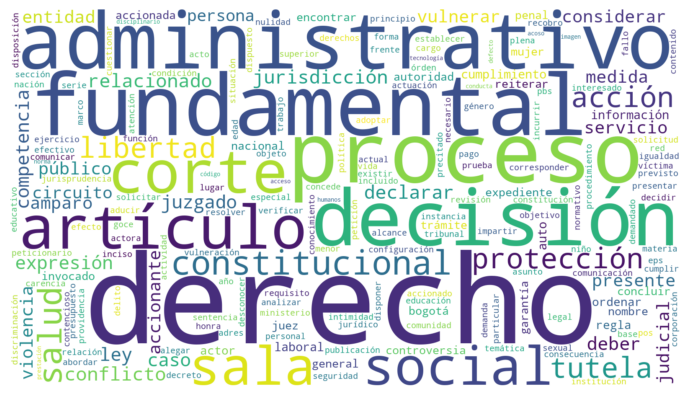

In [11]:
wc, freq_df = word_count_generator(legal_data)
word_plot(wc)

## "Hay muchos tipos de demandas, por esto, para la prueba, quieren concentrarse en demandas relacionadas a redes sociales." --> Vamos a filtrar las filtras que solo incluyen temática de redes sociales

In [13]:
TOPIC = [
    "red social", "redes sociales",
    "plataforma social", "plataformas sociales",
    "plataforma de medios sociales", "plataformas de medios sociales",
    "medio social", "medios sociales",
    "plataforma de interacción", "plataformas de interacción",
    "comunidad en línea", "comunidades en línea",
    "comunidad virtual", "comunidades virtuales",
    "plataforma digital", "plataformas digitales",
    "sitio de redes sociales", "sitios de redes sociales",
    "servicio de microblogging", "microblogging",

    "facebook", "meta",
    "instagram", "threads",
    "twitter", "x", "tweet", "tweets",
    "snapchat", "tiktok", "linkedin", "youtube", "yt", "reddit",
    "pinterest", "whatsapp", "wa", "telegram", "discord", "tumblr",
    "vimeo", "flickr",

    "red social corporativa",
    "foro en línea", "foros en línea",
    "plataforma de networking",
    "plataforma colaborativa",
]

In [14]:
filtered, len_df , len_filtered = filter_topic(legal_data, TOPIC)
#filtered.to_csv("legal_data_filtrado.csv", index=False, encoding="utf-8-sig")

C:\Users\enzo-\AppData\Local\Temp\ipykernel_21396\2272909803.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df[cols].astype(str).applymap(lambda v: bool(pattern.search(normalize(v)))).any(axis=1)


In [15]:
print(f"Filas retenidas: {len_filtered} · excluidas: {len_df-len_filtered}")

Filas retenidas: 83 · excluidas: 246


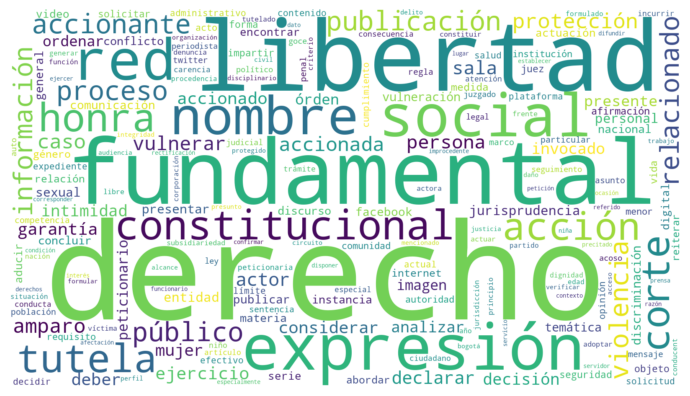

In [16]:
wc, freq_df = word_count_generator(filtered)
word_plot(wc)

### Con esta tabla filtrada, nosotros podemos ahora escoger 3 rows al azar, para resumirlas via LLMs

In [18]:
a, b, c = random.sample(range(len(filtered)), 3)
print(a,b,c)

62 73 4


In [19]:
tres_demandas = filtered.loc[[a, b, c]].reset_index(drop=True)
tres_demandas

,#,Relevancia,Providencia,Fecha Sentencia,Tema - subtema,resuelve,sintesis
0,134,702441.0,A. 1051/24,2024-06-19,NaN,RESUELVE Primero: DIRIMIR el conflicto negativ...,Conflicto de jurisdicciones entre el Juzgado 1...
1,246,512523.0,A. 709/24,2024-04-15,NaN,RESUELVE Primero. A través de Secretaría Gener...,Con el presente auto se convoca y define la me...
2,7,955787.0,T-245A/22,2022-07-01,ACCION DE TUTELA-Inexistencia de hecho superad...,en nombre del pueblo y por mandato de la Const...,"El accionante, actuando en representación de s..."


In [20]:
tres_demandas_con_LLMs = LLM_aumentation(tres_demandas)
#tres_demandas_con_LLMs.to_csv("tres_demandas_con_LLMs.csv", encoding="utf-8-sig")

✔︎ Model2 row2 (De_qué_trata_LLM) (try1)
✔︎ Model1 row1 (Sentencia_LLM) (try1)


✖︎ Model2 row2 (Sentencia_LLM) failed (try1): Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': 'max completion tokens reached before generating a valid document'}}


✔︎ Model1 row1 (De_qué_trata_LLM) (try1)
✔︎ Model3 row3 (De_qué_trata_LLM) (try1)
✔︎ Model3 row3 (Sentencia_LLM) (try1)
✔︎ Model3 row2 (Sentencia_LLM) (try2)


In [21]:
tres_demandas_con_LLMs

,#,Relevancia,Providencia,Fecha Sentencia,Tema - subtema,resuelve,sintesis,Sentencia_LLM,De_qué_trata_LLM
0,134,702441.0,A. 1051/24,2024-06-19,NaN,RESUELVE Primero: DIRIMIR el conflicto negativ...,Conflicto de jurisdicciones entre el Juzgado 1...,La Corte resolvió que el Juzgado 2° Penal del ...,La oficial de la Armada Nacional pidió que se ...
1,246,512523.0,A. 709/24,2024-04-15,NaN,RESUELVE Primero. A través de Secretaría Gener...,Con el presente auto se convoca y define la me...,La Corte Constitucional convoquó a varias enti...,Se convocó a las autoridades involucradas en u...
2,7,955787.0,T-245A/22,2022-07-01,ACCION DE TUTELA-Inexistencia de hecho superad...,en nombre del pueblo y por mandato de la Const...,"El accionante, actuando en representación de s...",La Corporación ordenó revocar una sentencia de...,El accionante pide al juez constitucional que ...


In [22]:
tres_demandas_con_LLMs['sintesis'].iloc[0]

'Conflicto de jurisdicciones entre el Juzgado 110 de Instrucción Penal Militar de Coveñas (Sucre) y el Juzgado Segundo Penal del Circuito con funciones de Conocimiento de Turbo (Antioquia). Se suscita la controversia por una querella interpuesta por una oficial de la Armada Nacional en el grado de Capitán de Corbeta, ante la fiscalía general de la Nación â€“ Unidad CTI Local de Turbo, contra un ciudadano, quien desempeñaba el cargo de sargento segundo en el Batallón Fluvial de Marina No. 16, por el presunto delito de injuria por vía de hecho. Luego de verificar el cumplimiento de los presupuestos para la configuración de un verdadero conflicto de jurisdicciones, la Sala Plena encuentra que las funciones del imputado al momento de ocurrencia de los hechos eran las del jefe de la sección de contrainteligencia del batallón fluvial de I.M. No. 16, ello permitiría concluir que las actuaciones del procesado estuvieron en el marco de sus funciones como autoridad naval al momento de solicitar 

In [23]:
tres_demandas_con_LLMs['Sentencia_LLM'].iloc[0]

'La Corte resolvió que el Juzgado 2° Penal del Circuito de Turbo tiene competencia para conocer el proceso penal contra Juan Gabriel Pedraza Carrillo, revocando la competencia del Juzgado 110 de Instrucción Penal Militar de Coveñas.'

In [24]:
tres_demandas_con_LLMs['De_qué_trata_LLM'].iloc[0]

'La oficial de la Armada Nacional pidió que se juzgue a un sargento por injuria y abuso de autoridad, pero la Sala Plena decidió que el caso no corresponde a la jurisdicción penal militar, sino a la ordinaria, ya que los hechos no están relacionados con sus funciones y tareas militares.'

## ¿Cuál fue la sentencia del caso que habla de acoso escolar? y ¿diga el detalle de la demanda relacionada con acoso escolar?

In [26]:
TOPIC = ["escolar"]  # base terms

filtered_acoso_escolar, len_filtered , len_filtered_acoso_escolar = filter_topic(filtered, TOPIC)

C:\Users\enzo-\AppData\Local\Temp\ipykernel_21396\2272909803.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df[cols].astype(str).applymap(lambda v: bool(pattern.search(normalize(v)))).any(axis=1)


In [27]:
print(f"Filas retenidas: {len_filtered_acoso_escolar} · excluidas: {len_filtered-len_filtered_acoso_escolar}")

Filas retenidas: 4 · excluidas: 79


In [28]:
filtered_acoso_escolar

,#,Relevancia,Providencia,Fecha Sentencia,Tema - subtema,resuelve,sintesis
0,56,878418.00,T-453/22,2022-12-13,ACCION DE TUTELA CONTRA DECISIONES DISCIPLINAR...,RESUELVE PRIMERO. REVOCAR la sentencia proferi...,La accionante considera que el SENA vulneró su...
1,79,826.62,T-400/20,2020-09-14,AGRESION ESCOLAR A TRAVES DE MEDIOS ELECTRONIC...,en nombre del pueblo y por mandato de la Const...,"La accionante, actuando en representación su h..."
2,87,817482.00,T-252/23,2023-07-10,ACCION DE TUTELA PARA RECLAMAR INDEMNIZACION D...,en nombre del pueblo y por mandato de la Const...,"La accionante, actuando en representación de s..."
3,122,733297.00,T-449/23,2023-10-27,ACOSO ESCOLAR O BULLYING-Manejo por parte de l...,RESUELVE PRIMERO. DECLARAR que existe una care...,La actora considera que la entidad accionada v...


In [29]:
filtered_acoso_escolar_con_LLMs = LLM_aumentation(filtered_acoso_escolar)
#filtered_acoso_escolar_con_LLMs.to_csv("filtered_acoso_escolar_con_LLMs.csv", encoding="utf-8-sig")

✔︎ Model2 row2 (De_qué_trata_LLM) (try1)
✔︎ Model1 row1 (De_qué_trata_LLM) (try1)


✖︎ Model2 row2 (Sentencia_LLM) failed (try1): Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': 'max completion tokens reached before generating a valid document'}}


✔︎ Model1 row1 (Sentencia_LLM) (try1)
✔︎ Model4 row4 (Sentencia_LLM) (try1)
✔︎ Model3 row2 (Sentencia_LLM) (try2)


✖︎ Model3 row3 (De_qué_trata_LLM) failed (try1): Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': 'max completion tokens reached before generating a valid document'}}


✔︎ Model3 row3 (Sentencia_LLM) (try1)


✖︎ Model4 row4 (De_qué_trata_LLM) failed (try1): Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': '```json\n{\n   "answer": "La actora pidió protección de sus derechos fundamentales violados luego de que la entidad accionada negara la matriculación de su hija en una jornada sabatina y no investigara casos de ciberacoso, y la Corte ordenó measures para proteger sus derechoa y garantizar su educación."'}}


✔︎ Model4 row3 (De_qué_trata_LLM) (try2)
✔︎ Model1 row4 (De_qué_trata_LLM) (try2)


In [30]:
filtered_acoso_escolar_con_LLMs

,#,Relevancia,Providencia,Fecha Sentencia,Tema - subtema,resuelve,sintesis,Sentencia_LLM,De_qué_trata_LLM
0,56,878418.00,T-453/22,2022-12-13,ACCION DE TUTELA CONTRA DECISIONES DISCIPLINAR...,RESUELVE PRIMERO. REVOCAR la sentencia proferi...,La accionante considera que el SENA vulneró su...,Melin Andrea Miranda Salgado solicitó amparo a...,La accionante pidió amparo contra el SENA por ...
1,79,826.62,T-400/20,2020-09-14,AGRESION ESCOLAR A TRAVES DE MEDIOS ELECTRONIC...,en nombre del pueblo y por mandato de la Const...,"La accionante, actuando en representación su h...",La Corte Suprema de Justicia resuelve revocar ...,"La accionante solicitó amparo para su hijo, qu..."
2,87,817482.00,T-252/23,2023-07-10,ACCION DE TUTELA PARA RECLAMAR INDEMNIZACION D...,en nombre del pueblo y por mandato de la Const...,"La accionante, actuando en representación de s...",El Poder Judicial revocó parcialmente una sent...,"La accionante, en nombre de su hijo menor, pid..."
3,122,733297.00,T-449/23,2023-10-27,ACOSO ESCOLAR O BULLYING-Manejo por parte de l...,RESUELVE PRIMERO. DECLARAR que existe una care...,La actora considera que la entidad accionada v...,La jueza ordenó al Colegio XYZ investigar el c...,La actora pidió que se garantizara el derecho ...


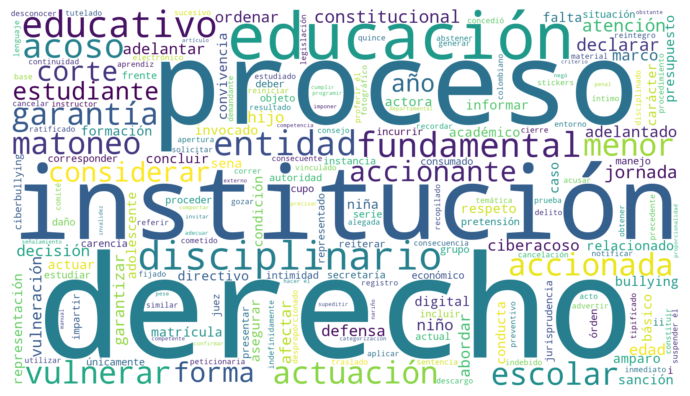

In [31]:
wc, freq_df = word_count_generator(filtered_acoso_escolar)
word_plot(wc)

## ¿existen casos que hablan sobre el PIAR, indique de que trataron los casos y cuáles fueron sus sentencias? 

In [33]:
TOPIC = ["PIAR", "Plan Individualizado de Ajustes Razonables"]  # base terms

filtered_PIAR, len_df , len_PIAR = filter_topic(legal_data, TOPIC) # si usamos el "filtered" no nos da resultados

C:\Users\enzo-\AppData\Local\Temp\ipykernel_21396\2272909803.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df[cols].astype(str).applymap(lambda v: bool(pattern.search(normalize(v)))).any(axis=1)


In [34]:
filtered_PIAR_con_LLMs = LLM_aumentation(filtered_PIAR)
#filtered_PIAR_con_LLMs.to_csv("filtered_PIAR_con_LLMs.csv", encoding="utf-8-sig")

✖︎ Model2 row2 (Sentencia_LLM) failed (try1): Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': 'max completion tokens reached before generating a valid document'}}


✔︎ Model1 row1 (Sentencia_LLM) (try1)
✔︎ Model1 row1 (De_qué_trata_LLM) (try1)


✖︎ Model2 row2 (De_qué_trata_LLM) failed (try1): Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': 'max completion tokens reached before generating a valid document'}}


✔︎ Model3 row2 (Sentencia_LLM) (try2)
✔︎ Model3 row2 (De_qué_trata_LLM) (try2)


In [35]:
filtered_PIAR_con_LLMs

,#,Relevancia,Providencia,Fecha Sentencia,Tema - subtema,resuelve,sintesis,Sentencia_LLM,De_qué_trata_LLM
0,140,657637.0,T-249/24,2024-06-26,NaN,RESUELVE Primero. REVOCAR la orden primera de ...,"La accionante, actuó como representante legal ...","Camila, como representante de su hija Paola, s...",La accionante pidió amparo por violación de de...
1,288,437249.0,T-085/23,2023-03-27,ACCESIBILIDAD Y ADAPTABILIDAD COMO COMPONENTES...,en nombre del pueblo y por mandato de la Const...,La accionante actúa en representación de un hi...,El Juez ordenó la revocación de sentencias y t...,La madre de un niño con síndrome Landau Kleffn...


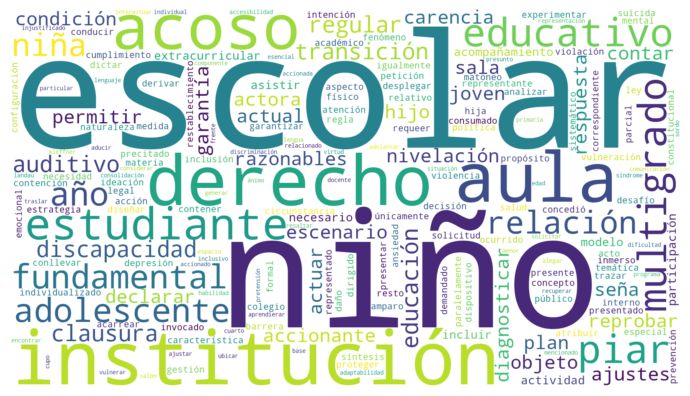

In [36]:
wc, freq_df = word_count_generator(filtered_PIAR)
word_plot(wc)